In [1]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

zsh:1: command not found: wget


In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('data/airline_passengers.csv', index_col='Month', parse_dates=True)

In [4]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


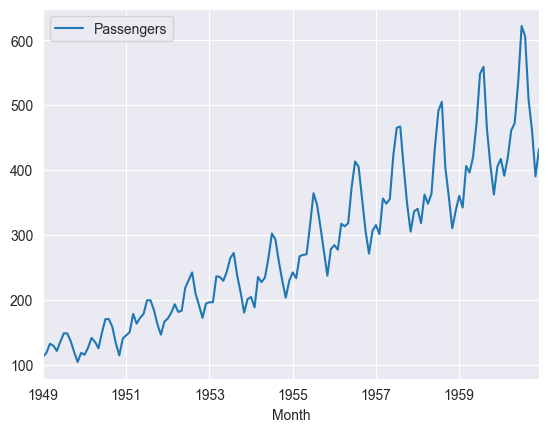

In [5]:
df.plot();

In [6]:
alpha = 0.2

In [7]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [8]:
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

In [9]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
  if len(manual_ewma) > 0:
    xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)
df['Manual'] = manual_ewma

<Axes: xlabel='Month'>

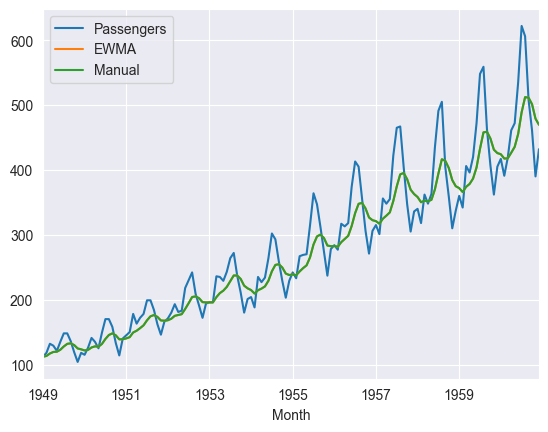

In [10]:
df.plot()

In [11]:
df.drop('Manual', axis=1, inplace=True)

In [12]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [13]:
ses = SimpleExpSmoothing(df['Passengers'])

/Users/tantravahiaditya/miniforge3/envs/pyfineng/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [14]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [15]:
df.index.freq = 'MS'

In [16]:
ses = SimpleExpSmoothing(df['Passengers'])

In [17]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [18]:
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [19]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [20]:
np.allclose(df['SES'], res.fittedvalues)

True

<Axes: xlabel='Month'>

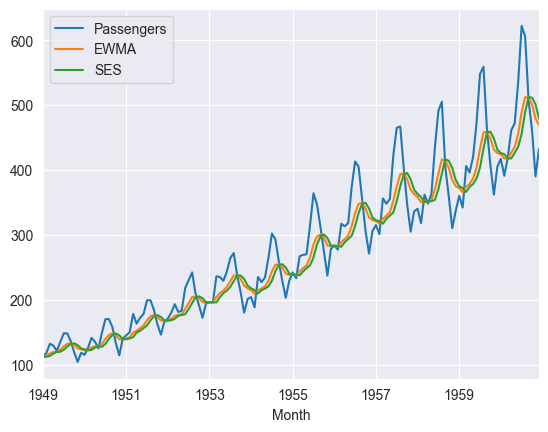

In [21]:
df.plot()

In [22]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [23]:
df['SES-1'] = df['SES'].shift(-1)

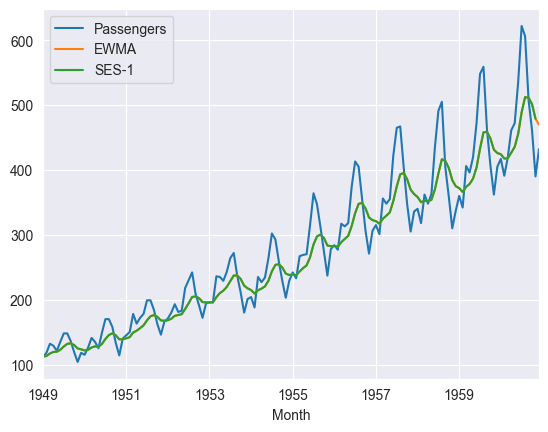

In [24]:
### Does not make sense
df[['Passengers', 'EWMA', 'SES-1']].plot();

In [25]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]


In [26]:
ses = SimpleExpSmoothing(train['Passengers'])
res = ses.fit()

In [27]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

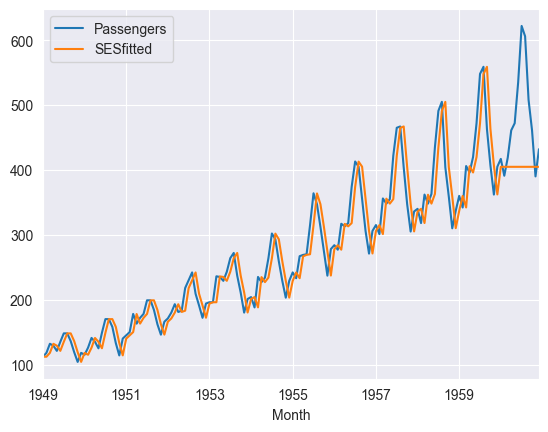

In [28]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['Passengers', 'SESfitted']].plot();